# Forecasting 10-Year US Notes

This notebook contains several steps related to building a predictive model for [US 10-Year Note Futures](https://www.cmegroup.com/markets/interest-rates/us-treasury/10-year-us-treasury-note.contractSpecs.html).  

**Outline:**

* [Initialize packages](#Initialize)
* [Load data](#Load-data)
* [Data preparation](#Data-preparation)
* [Roll futures](#Roll-futures)
* [Forecast 10-Year Notes](#Prediction)

**Instructions:**

Create a copy of the notebook and rename it: "ZN Forecast (*your name*)".  

The notebook assumes that you are using Python 3 and have two packages installed: pandas and pandas_datareader.  You may use any package or method to build the predictive model.  You may also use any of the data provided to build your model, including transformations of this data, but do not add any additional datasets.  You may modify this notebook however you want.

Make sure that you answer these questions as part of this exercise:

1. In the "data preparation" section: How should you modify this data in order to use it for the subsequent analysis?  Are there any problems with this data?
1. In the "roll futures" section: Compare your rolled futures to the ZN=F contract off Yahoo.  How is ZN=F different (e.g. what logic does it look like they use to roll)?
1. In the "forecast" section: Why is this a good (or bad) model?  What else might you do if you want to actually use this in the real world?

*(Optional bonus)* Output any pictures or tables and write your summary in a LaTeX report.



## Initialize

Load any packages that you want to use for the analysis.

In [55]:
!pip install scikit-learn

You should consider upgrading via the 'C:\Users\TATHAGATA\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.



     ---------------------------------------- 7.3/7.3 MB 1.1 MB/s eta 0:00:00


In [3]:
# Initial imports
import pandas as _pd
import pandas_datareader as _pdr
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import metrics
import numpy as np

In [4]:
_pd.__version__

'1.4.1'

In [5]:
_pdr.__version__

'0.10.0'

In [6]:
# Put any additional packages that you want to use here:
import matplotlib.pyplot as _plt

## Load data

Load data from Yahoo! and FRED.  (**Note**: You should not need to modify this section.

In [7]:
# Build a list of ZN contracts (Yahoo only has the last 3...)
ZN_month_codes = ['H', 'M', 'U', 'Z']
ZN_years = range(2022, 2023)
ZN_codes = []
for year in ZN_years:
    for month in ZN_month_codes:
        ZN_codes += ['ZN%(month)s%(year)s.CBT' % {"month": month, "year": str(year)[-2:]}]
        print(ZN_codes)

['ZNH22.CBT']
['ZNH22.CBT', 'ZNM22.CBT']
['ZNH22.CBT', 'ZNM22.CBT', 'ZNU22.CBT']
['ZNH22.CBT', 'ZNM22.CBT', 'ZNU22.CBT', 'ZNZ22.CBT']


In [8]:
zn_df = _pdr.DataReader(ZN_codes, 'yahoo', start='2003-01-01', end='2022-12-31')
tmp_df = zn_df.loc[:, ['Adj Close','Close']]
print(zn_df.xs('ZNU22.CBT', level=1, axis=1))
#print(zn_df['Close'].tail())

C:\Users\TATHAGATA\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'ZNH22.CBT', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


Attributes   Adj Close       Close        High         Low        Open  \
Date                                                                     
2021-09-20         NaN         NaN         NaN         NaN         NaN   
2021-09-21         NaN         NaN         NaN         NaN         NaN   
2021-09-22         NaN         NaN         NaN         NaN         NaN   
2021-09-23         NaN         NaN         NaN         NaN         NaN   
2021-09-24         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2022-06-15  115.155998  115.155998  115.953003  114.311996  114.344002   
2022-06-16  115.811996  115.811996  116.655998  114.311996  115.875000   
2022-06-17  116.188004  116.188004  116.594002  115.625000  116.453003   
2022-06-20  115.921997  115.921997  116.328003  115.765999  116.078003   
2022-06-21  116.015625  116.015625  116.328003  115.703003  116.078125   

Attributes     Volume  
Date         

In [9]:
zn_df.to_excel("C:\\Users\\TATHAGATA\\Downloads\\Main.xlsx")

<AxesSubplot:xlabel='Date'>

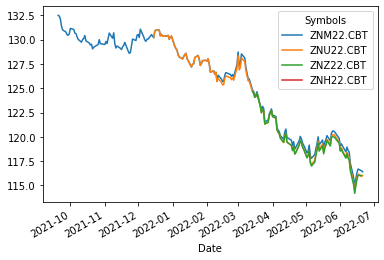

In [10]:
zn_df.xs('Close', level='Attributes', axis=1, drop_level=True).plot()

In [11]:
# Market data
market_df = _pdr.DataReader(['SPY', 'ZN=F', '^GSPC', '^VIX', '^TNX'], 'yahoo', start='2003-01-01', end='2022-12-31')
#print(market_df.xs('ZN=F', level=1, axis=1))
print(market_df.tail())

Attributes   Adj Close                                                  Close  \
Symbols            SPY        ZN=F        ^GSPC       ^VIX   ^TNX         SPY   
Date                                                                            
2022-06-15  377.569031  115.687500  3789.989990  29.620001  3.395  379.200012   
2022-06-16  365.072998  116.343750  3666.770020  32.950001  3.307  366.649994   
2022-06-17  365.859985  116.687500  3674.840088  31.129999  3.239  365.859985   
2022-06-20         NaN  116.515625          NaN        NaN    NaN         NaN   
2022-06-21         NaN  116.015625          NaN  30.270000    NaN         NaN   

Attributes                                             ...        Open  \
Symbols           ZN=F        ^GSPC       ^VIX   ^TNX  ...         SPY   
Date                                                   ...               
2022-06-15  115.687500  3789.989990  29.620001  3.395  ...  377.359985   
2022-06-16  116.343750  3666.770020  32.950001  3.307  

In [12]:
market_df.to_excel("C:\\Users\\TATHAGATA\\Downloads\\Market.xlsx")

In [13]:
# Macroeconomic data
fred_df = _pdr.DataReader(['WM2NS', 'M2V', 'T10Y2Y', 'T5YIE', 'GDP', 'USACPIALLMINMEI', 'UNRATE'], 'fred', "2003-01-01", "2022-12-31")
print(fred_df['WM2NS'].isnull().sum())
print(fred_df[fred_df['GDP'].notnull()])
#print(fred_df.describe)

4136
            WM2NS    M2V  T10Y2Y  T5YIE        GDP  USACPIALLMINMEI  UNRATE
DATE                                                                       
2003-01-01    NaN  1.915     NaN    NaN  11174.129        76.661168     5.8
2003-04-01    NaN  1.901    2.34   1.64  11312.766        77.547180     6.0
2003-07-01    NaN  1.905    2.26   1.45  11566.669        77.589371     6.2
2003-10-01    NaN  1.940    2.49   1.84  11772.234        78.053473     6.0
2004-01-01    NaN  1.950     NaN    NaN  11923.447        78.137855     5.7
...           ...    ...     ...    ...        ...              ...     ...
2021-01-01    NaN  1.124     NaN    NaN  22038.226       110.364235     6.4
2021-04-01    NaN  1.119    1.52   2.55  22740.959       112.672931     6.0
2021-07-01    NaN  1.114    1.23   2.49  23202.344       115.182877     5.4
2021-10-01    NaN  1.126    1.21   2.51  24002.815       116.695849     4.6
2022-01-01    NaN  1.122     NaN    NaN  24384.289       118.619340     4.0

[77 ro

In [14]:
fred_df.to_excel("C:\\Users\\TATHAGATA\\Downloads\\Eco.xlsx")

## Data preparation

This section relates to preparing the data to be used in a predictive model.  You can combine **market_df** and **fred_df** from the [load data](#Load-data) section together, along with any transformations for the data, into a final **model_df** data frame.

In [15]:
# Any data manipulation steps (feel free to add additional cells, etc.)

In [16]:
md = _pd.read_excel("stock(final).xlsx")

In [17]:
market = _pd.read_excel("market.xlsx")

In [18]:
eco = _pd.read_excel("economic.xlsx")

In [19]:
md.head()

,Date,Adj Close (ZNM22.CBT),SPY,ZN=F,^GSPC,^VIX,^TNX,WM2NS,M2V,T10Y2Y,T5YIE,GDP,USACPIALLMINMEI,UNRATE
0,2021-09-20,132.156998,429.326385,133.843750,4357.729980,25.709999,1.309,20960.8,1.114,1.08,2.43,23202.344,115.734314,4.7
1,2021-09-21,132.078995,428.920837,133.859375,4354.189941,24.360001,1.324,20960.8,1.114,1.11,2.44,23202.344,115.734314,4.7
2,2021-09-22,131.781998,433.104858,132.984375,4395.640137,20.870001,1.336,20960.8,1.114,1.07,2.41,23202.344,115.734314,4.7
3,2021-09-23,131.031998,438.367096,132.375000,4448.979980,18.629999,1.410,20960.8,1.114,1.14,2.48,23202.344,115.734314,4.7
4,2021-09-24,130.656998,439.089203,132.015625,4455.479980,17.750000,1.460,20960.8,1.114,1.18,2.47,23202.344,115.734314,4.7


In [20]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   189 non-null    datetime64[ns]
 1   Adj Close (ZNM22.CBT)  189 non-null    float64       
 2   SPY                    189 non-null    float64       
 3   ZN=F                   189 non-null    float64       
 4   ^GSPC                  189 non-null    float64       
 5   ^VIX                   189 non-null    float64       
 6   ^TNX                   189 non-null    float64       
 7   WM2NS                  189 non-null    float64       
 8   M2V                    189 non-null    float64       
 9   T10Y2Y                 189 non-null    float64       
 10  T5YIE                  189 non-null    float64       
 11  GDP                    189 non-null    float64       
 12  USACPIALLMINMEI        189 non-null    float64       
 13  UNRAT

# Checking the correlation between predictor variables

In [21]:
correlation = md.corr()

<AxesSubplot:>

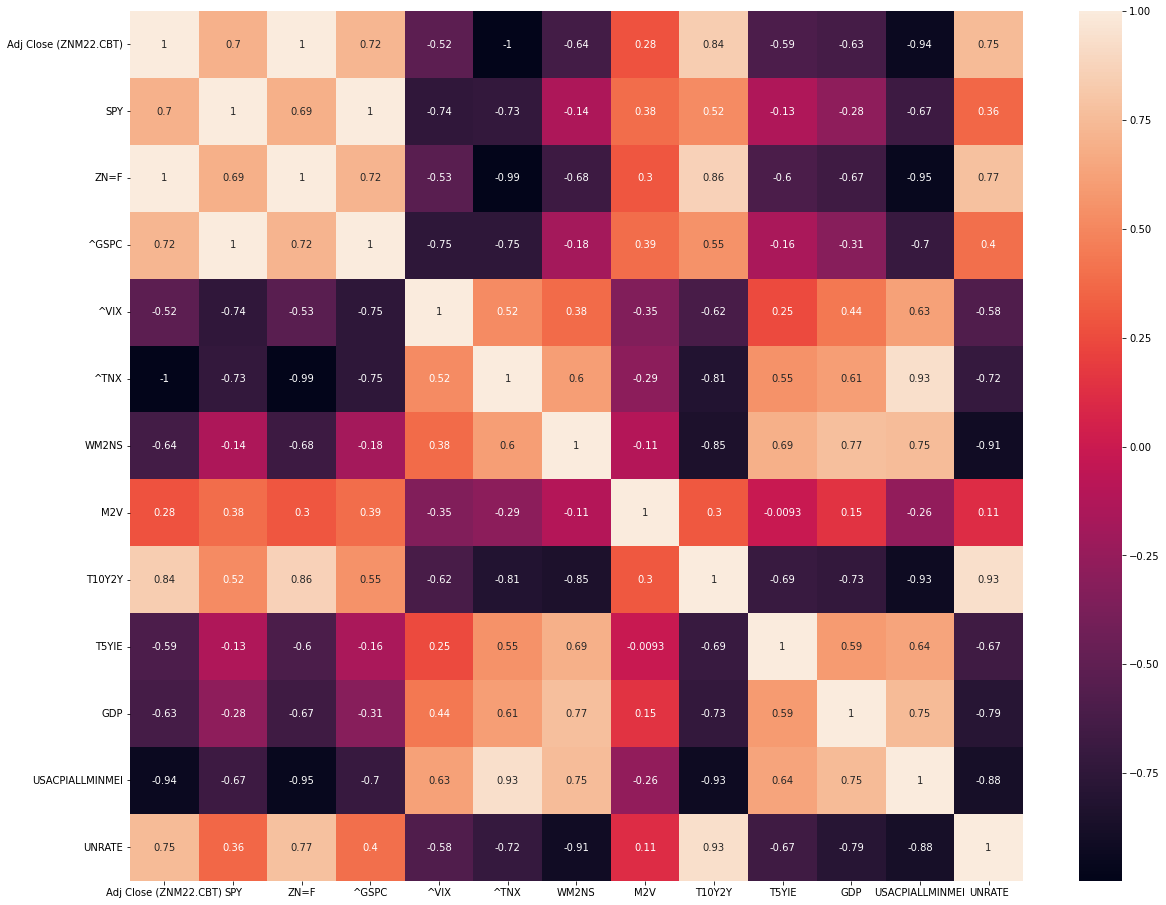

In [22]:
plt.figure(figsize=(20, 16))
sns.heatmap(correlation, annot = True)

array([[<AxesSubplot:xlabel='Adj Close (ZNM22.CBT)', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='SPY', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='ZN=F', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='^GSPC', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='^VIX', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='^TNX', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='WM2NS', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='M2V', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='T10Y2Y', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='T5YIE', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='GDP', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='USACPIALLMINMEI', ylabel='Adj Close (ZNM22.CBT)'>,
        <AxesSubplot:xlabel='UNRATE', ylabel='Adj Close (ZNM22.CBT)'>],
       [<AxesSubplot:xlabel='Adj Close (ZNM22.CBT)', ylabel='SPY'>,
  

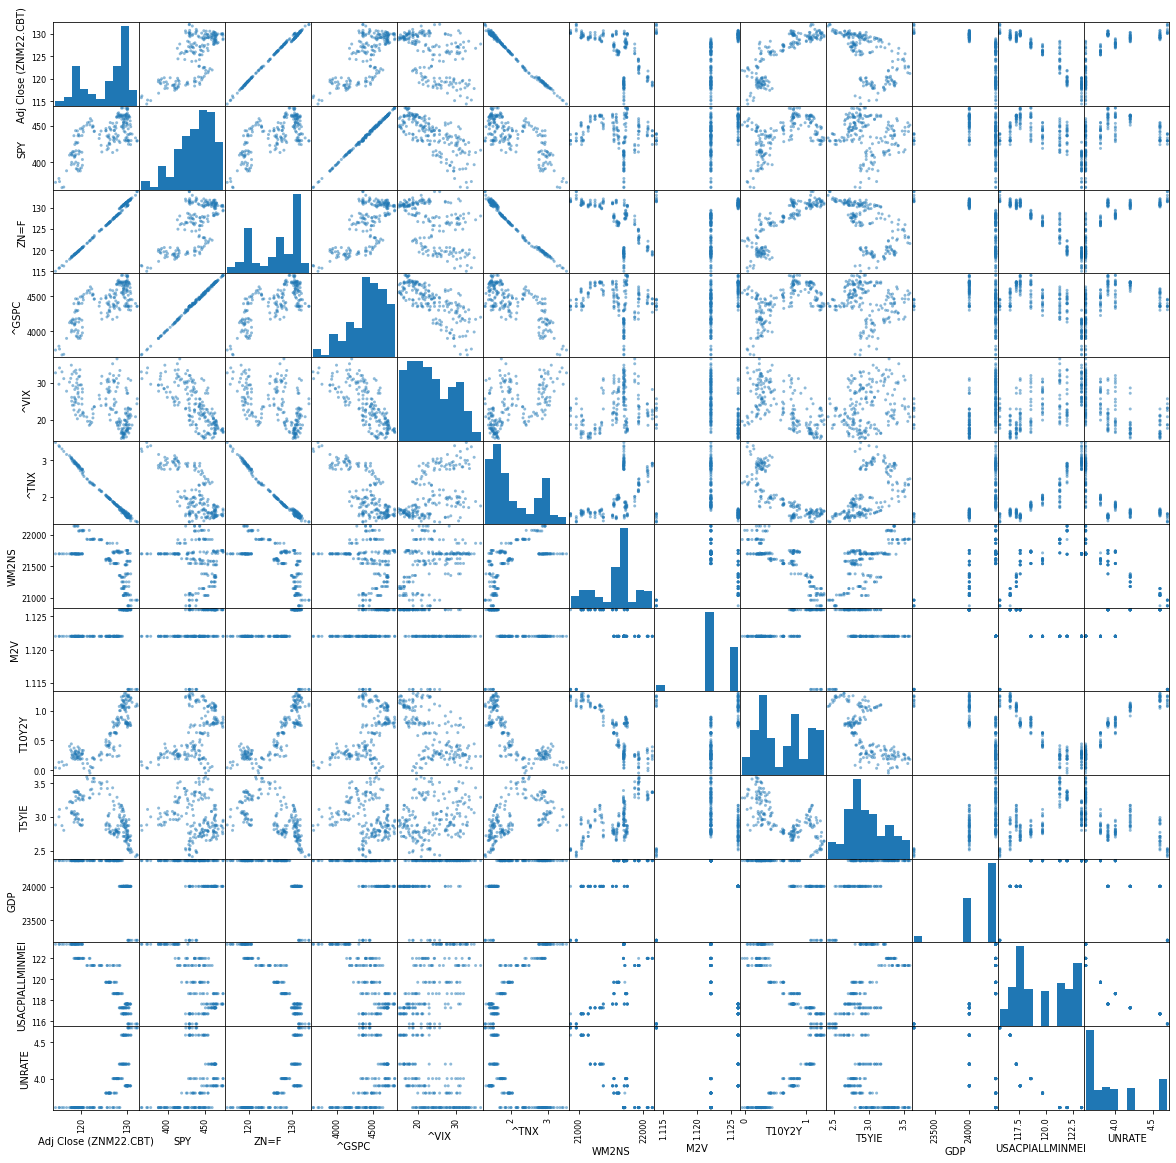

In [23]:
scatter_matrix(md, figsize = (20,20))

In [24]:
correlationmarket = market.corr()
correlationeco = eco.corr()

<AxesSubplot:>

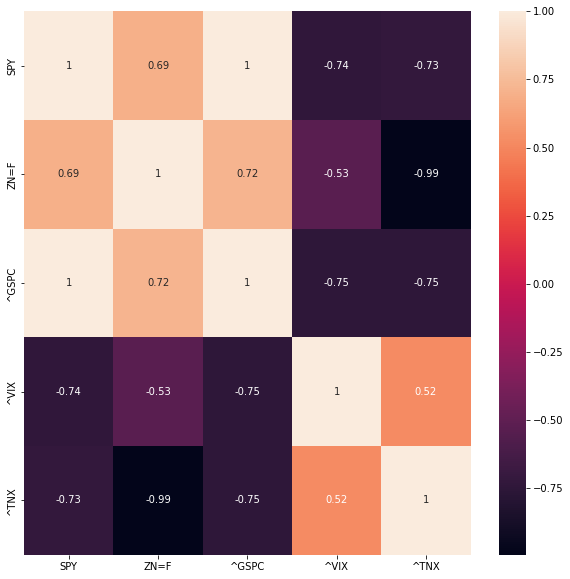

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlationmarket, annot = True)

In [26]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr

In [27]:
corr_features = correlation(correlationmarket, 0.85)
len(set(corr_features))

4

In [28]:
corr_features

{'ZN=F', '^GSPC', '^TNX', '^VIX'}

<AxesSubplot:>

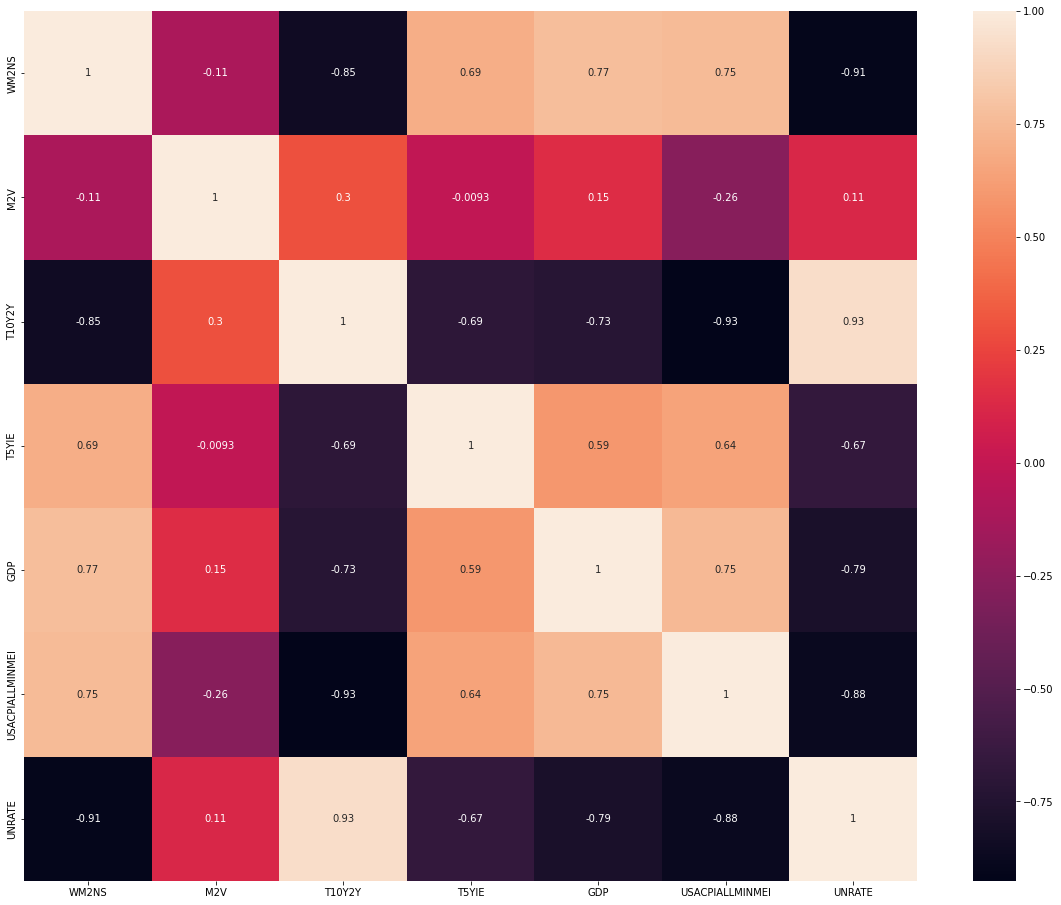

In [29]:
plt.figure(figsize=(20, 16))
sns.heatmap(correlationeco, annot = True)

In [30]:
corr_features = correlation(correlationeco, 0.85)
len(set(corr_features))

5

In [31]:
corr_features

{'GDP', 'T10Y2Y', 'T5YIE', 'UNRATE', 'USACPIALLMINMEI'}

## Prediction

Build a model to predict ZN based on any of the **model_df** data frame from the [data preparation](#Data-preparation) section.  (Note: You are not required to use all the variables.)

In [32]:
# Build a prediction model on the continuous ZN instrument (feel free to add additional cells, etc.)

# Multiple Linear Regression model

In [33]:
x = md[['SPY','^VIX','M2V','T5YIE','GDP','USACPIALLMINMEI','WM2NS']]
y = md['Adj Close (ZNM22.CBT)']

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [35]:
x_train.shape

(141, 7)

In [36]:
x_test.shape

(48, 7)

In [37]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

In [38]:
regressor.fit(x_train, y_train)

LinearRegression()

In [39]:
print(regressor.coef_)

[ 6.08618032e-02  2.27023903e-01 -2.36802218e+00 -1.16785323e+00
  8.87857637e-04 -1.62330491e+00 -8.66609554e-04]


In [40]:
coeff_df = _pd.DataFrame(regressor.coef_, x.columns, columns=['Coefficient'])
coeff_df

,Coefficient
SPY,0.060862
^VIX,0.227024
M2V,-2.368022
T5YIE,-1.167853
GDP,0.000888
USACPIALLMINMEI,-1.623305
WM2NS,-0.000867


In [41]:
print(regressor.intercept_)

290.9716855527092


In [42]:
predicted = regressor.predict(x_test)

In [43]:
print(x_test)

            SPY       ^VIX    M2V  T5YIE        GDP  USACPIALLMINMEI    WM2NS
108  418.833984  31.020000  1.122   3.01  24384.289       119.702806  21619.5
74   474.023376  16.910000  1.122   2.93  24384.289       118.619340  21724.9
161  397.373444  32.990002  1.122   2.92  24384.289       123.322800  21696.8
95   443.301941  24.350000  1.122   2.76  24384.289       119.702806  21541.0
123  432.403015  26.670000  1.122   3.34  24384.289       121.301004  21921.4
71   472.643646  17.330000  1.126   2.86  24002.815       117.629537  21750.1
18   437.694489  16.860001  1.126   2.69  24002.815       116.695849  21067.8
124  437.812775  25.670000  1.122   3.51  24384.289       121.301004  21921.4
143  441.403259  21.820000  1.122   3.25  24384.289       121.978170  22059.2
7    429.731903  22.559999  1.114   2.52  23202.344       115.734314  20871.9
5    437.832977  18.760000  1.114   2.50  23202.344       115.734314  20871.9
186  377.569031  29.620001  1.122   3.00  24384.289       123.32

In [44]:
df = _pd.DataFrame({'Actual': y_test, 'Predicted': predicted})
df

,Actual,Predicted
108,125.875999,125.932759
74,128.735001,127.849261
161,118.437996,119.235633
95,127.187996,126.267665
123,123.890999,122.529657
71,129.953995,129.179134
18,130.078995,129.250848
124,123.985001,122.433346
143,120.453995,120.862802
7,130.110001,131.307146


In [45]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predicted))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

Mean Absolute Error: 0.9748792402597365
Mean Squared Error: 1.608650699396344
Root Mean Squared Error: 1.2683259436739218


In [46]:
from sklearn.metrics import r2_score

In [47]:
r2_score(y_test, predicted)

0.9260119401227048

In [53]:
print(regressor.n_features_in_)

7


## Roll futures

Using the **zn_df** dataframe from [load data](#Load-data) section, create a continuous (generic) futures contract.

In [11]:
# Roll the futures contracts (feel free to add additional cells, etc.)